In [1]:
import os
import numpy as np
from pandas import DataFrame, read_csv

## Section 1: Parameter recovery

In [2]:
## Load data.
recovery = read_csv(os.path.join('stan_results', 'recovery.tsv.gz'), sep='\t', 
                    compression='gzip', index_col='name')

## Define parameter.
recovery['param'] = [s.split('[')[0] for s in recovery.index]

### 1.1 Consistency

In [3]:
## Define convenience function.
corr = lambda x: x.corr(method='pearson').loc['Latent','Mean']

## Compute consistency by parameter, model, & seed.
consistency = recovery.groupby(['param','model','seed']).apply(corr)
consistency = consistency.reset_index().rename(columns={0:'rho'})

## Restrict to parameters of interest.
consistency = consistency[consistency.param.isin(['theta','beta','alpha'])]

## Print information.
consistency.groupby(['param','model']).rho.describe().round(3)

count   mean    std    min    25%    50%    75%    max
param model                                                         
alpha 3pl_m2  100.0  0.667  0.056  0.449  0.640  0.675  0.701  0.765
      3pl_m3  100.0  0.671  0.054  0.467  0.646  0.681  0.706  0.769
beta  3pl_m2  100.0  0.962  0.003  0.953  0.960  0.962  0.964  0.973
      3pl_m3  100.0  0.962  0.003  0.953  0.960  0.962  0.964  0.973
theta 3pl_m2  100.0  0.873  0.004  0.861  0.870  0.873  0.875  0.884
      3pl_m3  100.0  0.873  0.005  0.861  0.870  0.873  0.875  0.884

### 1.2 Contrasts

In [4]:
## Restrict to group-level varables.
tpr = recovery.T.filter(regex='_mu\[[2-5]\]').T.copy()

## Define contrast level.
tpr['level'] = np.tile(['Large','Small'], len(tpr) // 2)

## Determine if 95% HDI excludes zero.
excludes_zero = lambda x: np.sign(x['2.5%']) == np.sign(x['97.5%'])
tpr['ez'] = tpr.apply(excludes_zero, 1)

## Compute TPR by model, parameter, & level.
tpr = tpr.groupby(['model','param','level']).ez.mean().reset_index(name='tpr')

## Print information.
tpr.pivot_table('tpr', ['model','param'], 'level')

level            Large  Small
model  param                 
3pl_m2 alpha_mu   0.72  0.435
       beta_mu    1.00  1.000
3pl_m3 alpha_mu   0.70  0.400
       beta_mu    1.00  1.000

### 1.3 Model comparison

In [5]:
## Restrict to CV-LOO.
loo = recovery.T.filter(regex='loo').T

## Pivot data.
loo = -2 * loo.pivot_table('Latent', 'seed', 'model')

## Compute difference.
loo['delta'] = loo['3pl_m3'] - loo['3pl_m2']

## Print information.
loo.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
3pl_m2,100.0,26961.7,166.9,26569.0,26869.7,26975.0,27051.6,27464.5
3pl_m3,100.0,26962.2,167.0,26564.0,26870.2,26974.9,27051.8,27465.3
delta,100.0,0.5,4.0,-12.5,-1.5,0.9,3.3,7.0


## Section 2: Assembly

In [6]:
## Load assembly data.
assembly = read_csv(os.path.join('stan_results', 'assembly.tsv.gz'), sep='\t', compression='gzip')

## Format data.
assembly = assembly.replace({'observed':'Simulated', 'predicted':'Recovered'})

### 2.1 Test information function

In [7]:
## Melt data.
tif = assembly.melt(id_vars=['model','param','form'], var_name='theta', value_name='tif',
                    value_vars=['-1.0','-0.5','0.0','0.5','1.0'])

## Print information.
pivot = tif.pivot_table('tif', ['model','param'], 'theta').round(3)
pivot[['-1.0','-0.5','0.0','0.5','1.0']]

theta              -1.0   -0.5    0.0    0.5    1.0
model  param                                       
3pl_m2 Recovered  2.135  3.226  3.775  3.427  2.502
       Simulated  2.255  3.542  4.242  3.886  2.788
3pl_m3 Recovered  2.138  3.246  3.804  3.455  2.522
       Simulated  2.255  3.542  4.242  3.886  2.788

### 2.2 Reliability

In [8]:
## Print information.
assembly.groupby(['model','param']).reliability.describe().round(3)

count   mean    std    min    25%    50%    75%    max
model  param                                                            
3pl_m2 Recovered  300.0  0.706  0.017  0.653  0.697  0.707  0.718  0.756
       Simulated  300.0  0.726  0.010  0.692  0.720  0.727  0.733  0.750
3pl_m3 Recovered  300.0  0.708  0.015  0.652  0.698  0.708  0.718  0.743
       Simulated  300.0  0.726  0.010  0.692  0.720  0.727  0.733  0.750

## Section 3: Plotting

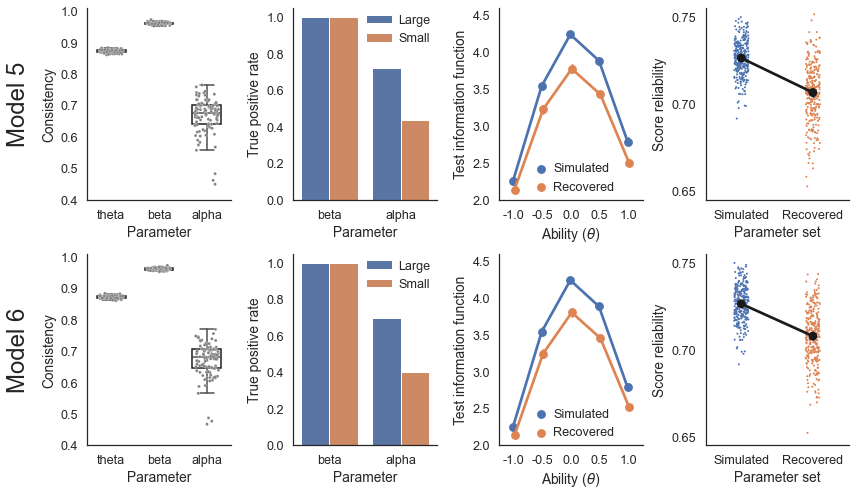

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white', context='notebook', font_scale=1.15)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define annotation settings.
annot_pos = (-0.00, 1.01)
annot_ha  = 'center'
annot_fs  = 24

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,7))

for i, model in enumerate(['3pl_m2', '3pl_m3']):

    ## Define query.
    query = f'model == "{model}"'
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Column #1: Parameter recovery.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize plot.
    ax = plt.subplot2grid((2,4), (i,0))
    order = ['theta','beta','alpha']

    ## Plot consistency.
    sns.stripplot(x='param', y='rho', data=consistency.query(query), order=order, color='grey',
                  size=3, jitter=0.25, linewidth=0.2, edgecolor='w', ax=ax)
    sns.boxplot(x='param', y='rho', data=consistency.query(query), order=order, 
                width=0.6, fliersize=0, boxprops=dict(facecolor='none', edgecolor='k'), ax=ax)

    ## Add detail.
    ax.set(xlabel='Parameter', ylabel='Consistency', ylim=(0.4,1.01))
    
    ## Add annotation.
    ax.annotate(f'Model {i+5}', (0,0), (-0.4,0.5), 'axes fraction', rotation=90,
                fontsize=24, va='center', ha='right')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Column #2: Contrast TPR.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize plot.
    ax = plt.subplot2grid((2,4), (i,1))
    order = ['beta_mu', 'alpha_mu']
    
    ## Plot true positive rate.
    sns.barplot(x='param', y='tpr', hue='level', data=tpr.query(query), order=order, ax=ax)
    
    ## Add detail.
    ax.set(xticklabels=['beta','alpha'], xlabel='Parameter', ylabel='True positive rate')
    ax.legend(loc=1, frameon=False, borderpad=0, handletextpad=0.5)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Column #3: TIF.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize plot.
    ax = plt.subplot2grid((2,4), (i,2))
    order = ['-1.0','-0.5','0.0','0.5','1.0']
    
    ## Plot test information function.
    sns.pointplot(x='theta', y='tif', hue='param', data=tif.query(query), order=order, 
                  dodge=True, ax=ax)
    
    ## Add detail.
    ax.set(xlabel=r'Ability ($\theta$)', ylim=(2.0,4.6), ylabel='Test information function')
    ax.legend(loc=8, frameon=False, borderpad=0, handletextpad=0)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Column #4: Reliability.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize plot.
    ax = plt.subplot2grid((2,4), (i,3))
    order=['Simulated','Recovered']
    
    ## Plot reliability.
    sns.stripplot(x='param', y='reliability', data=assembly.query(query), order=order,
                  size=2, zorder=-10, ax=ax)
    sns.pointplot(x='param', y='reliability', data=assembly.query(query), order=order,
                  color='k', ax=ax)
    
    ## Add detail.
    ax.set(xlabel='Parameter set', xticklabels=['Simulated','Recovered'], ylim=(0.645,0.755), 
           yticks=[0.65,0.70,0.75], ylabel='Score reliability')

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join('..', '05_Figures', 'figS04.png'), dpi=100)